# 1D Vlasov equation

We start with Vlasov equation with prescribed constant electric field $E(x,t) = A$ and no magnetic field $B(x,t) = 0$.

$$
\frac{\partial f}{\partial t} + v \frac{\partial f}{\partial x} +E  \frac{\partial f}{\partial u} = 0 
$$
where $u = \gamma v$ stands for spatial component of the four-velocity and $\gamma = \sqrt{1 + u^2}$ is the Lorentz factor (for simplicity we assume $m = 1$ so there is no difference between four-momentum and four-velocity). 
This choice allows analytic solution using the method of characteristics. Let's re-write the Vlasov equation in terms of four-velocity vector $u$:
$$
\frac{\partial f}{\partial t} + \frac{u}{\sqrt{1+u^2}} \frac{\partial f}{\partial x} + A  \frac{\partial f}{\partial u} = 0
$$

The solution is
$$
f = F\big( u-A t\,,\, A x - \gamma \big),
$$
where $F$ is an arbitrary function of its arguments given above

In [41]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pysindy as ps

Prepare the coordinate space

In [42]:
t = np.linspace(0, 2, 100)
x = np.linspace(-2, 2, 200)
u = np.linspace(-3, 3, 150)
v = np.sqrt(1+u**2)
A = 1
X3D, U3D, T3D = np.meshgrid(x, u, t, indexing="ij")
V3D = U3D/np.sqrt(1+U3D**2)
XUT = np.transpose([X3D, U3D, T3D], [1, 2, 3, 0])
print(f"{X3D.shape=}, {U3D.shape=}, {T3D.shape=}, {XUT.shape=}")

X3D.shape=(200, 150, 100), U3D.shape=(200, 150, 100), T3D.shape=(200, 150, 100), XUT.shape=(200, 150, 100, 3)


We choose $F(\xi,\eta) = \exp(-(\eta+A)^2 - \xi^2)$ with disregard to normalization of $F$ since we are mostly interested in recovering equation from data but not about physical consistency

In [43]:
Xi = U3D -  A*T3D
Eta = A*X3D - np.sqrt(1+U3D**2)
F = np.exp(-(Eta+A)**2-Xi**2)
E = A*np.ones_like(X3D)
#F = F/np.trapz(F, v, axis=1)[:,np.newaxis,:] # normalizing F just in case

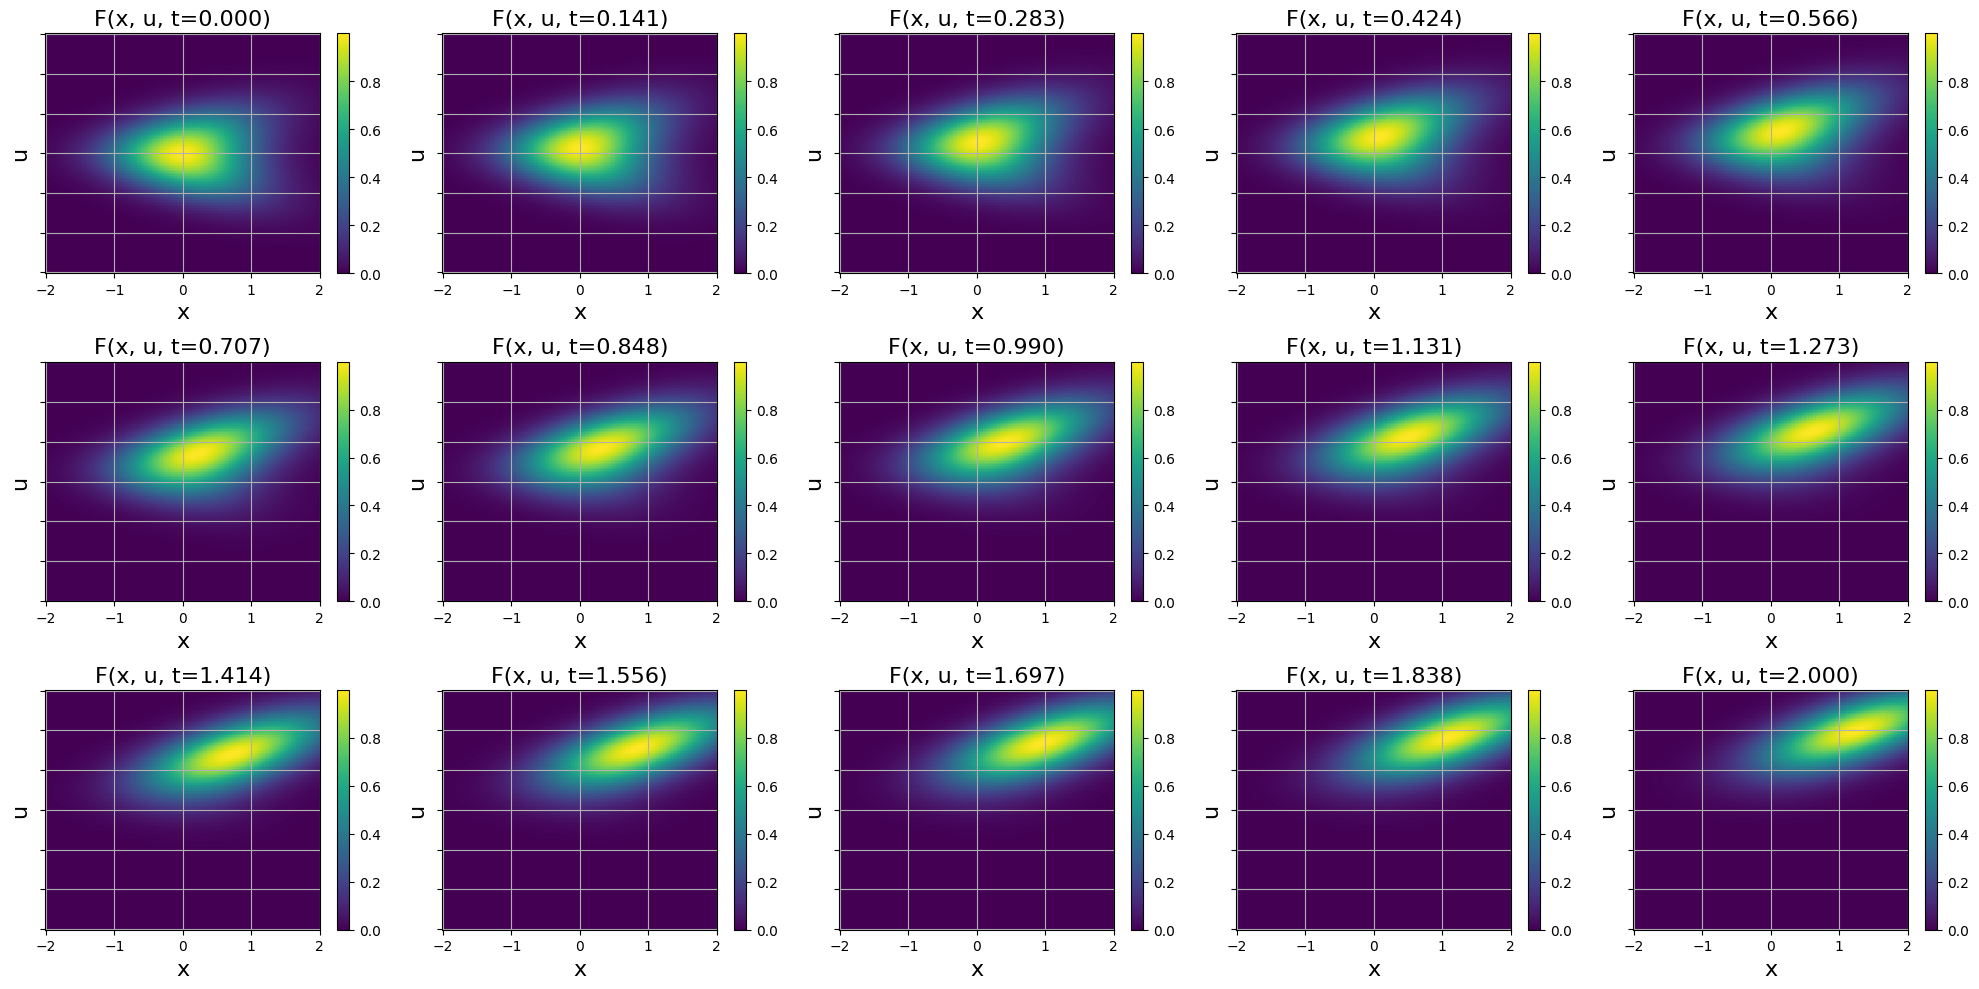

In [44]:
plt.figure(figsize=(20, 10))

for i, time in enumerate(np.linspace(0, len(t)-1, 15, dtype=int)):
    plt.subplot(3, 5, i+1)
    plt.pcolor(X3D[:,:,time], U3D[:,:,time], F[:, :, time])
    plt.xlabel("x", fontsize=16)
    plt.ylabel("u", fontsize=16)
    ax = plt.gca()
    ax.set_yticklabels([])
    plt.title(f"F(x, u, t={t[time]:.3f})", fontsize=16)
    plt.colorbar()
    plt.grid()

plt.tight_layout()
plt.show()


The result is that at some point the particles are accelerated to infinity which doesn't make sense physically. 

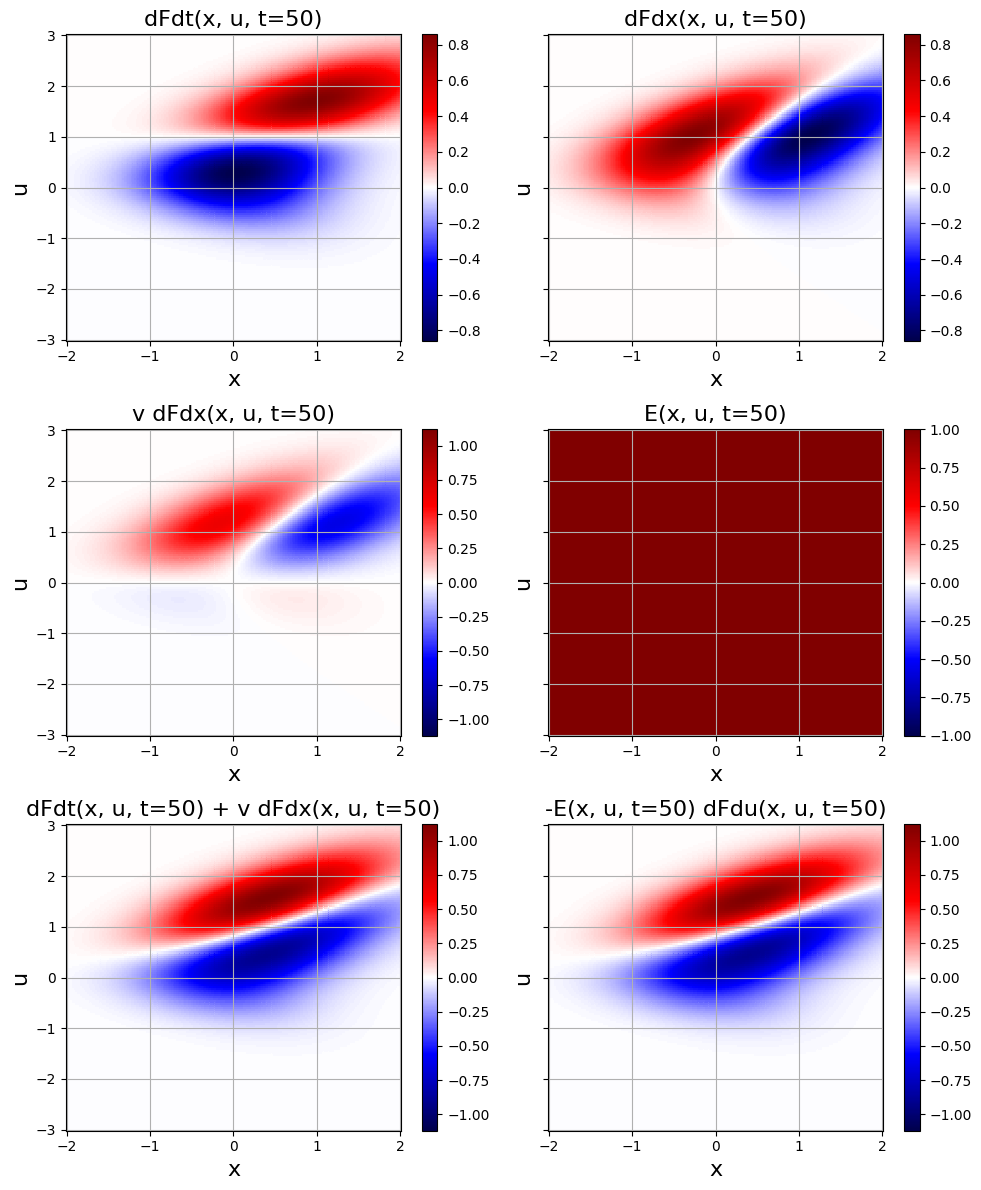

In [45]:
time = 50

dFdt = ps.SmoothedFiniteDifference(axis=2,smoother_kws={'window_length': 5})._differentiate(F, t=t)
dFdx = ps.SmoothedFiniteDifference(axis=0,smoother_kws={'window_length': 5})._differentiate(F, t=x)
dFdu = ps.SmoothedFiniteDifference(axis=1,smoother_kws={'window_length': 5})._differentiate(F, t=u)

plt.figure(figsize=(10, 12))

plt.subplot(3, 2, 1)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], dFdt[:, :, time], norm=colors.CenteredNorm(), cmap="seismic")
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
plt.title(f"dFdt(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 2)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], dFdx[:, :, time], norm=colors.CenteredNorm(), cmap="seismic")
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(f"dFdx(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 4)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], E[:,:,time], norm=colors.CenteredNorm(), cmap="seismic")
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(f"E(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 6)
pcm = plt.pcolor(X3D[:,:,time], U3D[:,:,time], -E[:,:,time]*dFdu[:, :, time], norm=colors.CenteredNorm(), cmap="seismic")
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(f"-E(x, u, t={time}) dFdu(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 5)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], dFdt[:, :, time] +V3D[:,:,time]*dFdx[:, :, time], cmap="seismic",vmin=pcm.norm.vmin,vmax=pcm.norm.vmax)
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
plt.title(f"dFdt(x, u, t={time}) + v dFdx(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 3)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], V3D[:,:,time]*dFdx[:, :, time], cmap="seismic",vmin=pcm.norm.vmin,vmax=pcm.norm.vmax)
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
plt.title(f"v dFdx(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.tight_layout()
plt.show()


In [46]:
# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x
]
library_function_names = [
    lambda x: x,
    lambda x: x + x
]

np.random.seed(100)

weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XUT,
    K=100,
)

So first I tried `normalize_columns = True` but that had very poor results

In [32]:
threshold = 0.2
alpha = 0.1
optimizer = ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True)
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
model.fit(F[...,np.newaxis], u =V3D)
model.print()

(x0)' = 0.000


Instead, when I take `normalize_columns=False` the equation is recovered, although generally very small `alpha` is required. Why?

In [52]:
for threshold in [0.05, 0.09,0.1, 0.15, 0.2, 0.021,0.03]: # parameter sweep for threshold of coefficient elimination
    print("==========================================")
    for alpha in [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,0.05,0.1,0.5,1,10,100,1000]:   # parameter sweep for alpha of ridge regression
        optimizer = ps.STLSQ(threshold=threshold, alpha=alpha)
        model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
        model.fit(F[...,np.newaxis], u =V3D)
        print(f"threshold = {threshold:.3e}, alpha = {alpha:.3e}", end="\t")
        model.print()

threshold = 5.000e-02, alpha = 1.000e-08	(x0)' = -1.000 x0_2 + -1.000 u0x0_1
threshold = 5.000e-02, alpha = 1.000e-07	(x0)' = -1.000 x0_2 + -1.000 u0x0_1
threshold = 5.000e-02, alpha = 1.000e-06	(x0)' = -1.000 x0_2 + -1.000 u0x0_1
threshold = 5.000e-02, alpha = 1.000e-05	(x0)' = -1.000 x0_2 + -0.001 x0x0_1 + -1.000 u0x0_1
threshold = 5.000e-02, alpha = 1.000e-04	(x0)' = -0.578 x0_2 + -0.072 u0_2 + 0.093 x0_11 + -0.257 x0x0_2 + 0.455 u0x0_2 + -0.381 u0u0x0_2
threshold = 5.000e-02, alpha = 1.000e-03	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-02	(x0)' = 0.000
threshold = 5.000e-02, alpha = 5.000e-02	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-01	(x0)' = 0.000
threshold = 5.000e-02, alpha = 5.000e-01	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e+00	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e+01	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e+02	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e+03	(x0)' = 0.000
threshold = 9.000e-02, alpha = 1.000e-08	(x

## non-relativistic case

Assuming $v << 1$ we get $u \approx v$ and $\gamma \approx 1$. The Vlasov equation becomes
$$
\frac{\partial f}{\partial t} + v\frac{\partial f}{\partial x} + A  \frac{\partial f}{\partial v} = 0
$$
Using the method of characteristics again we get
$$
f = F\big( v-A t\,,\, A x - \frac{v^2}{2} \big),
$$
where $F$ is an arbitrary function of its arguments given above

In [53]:
t = np.linspace(0, 2, 100)
x = np.linspace(-2, 2, 200)
u = np.linspace(-3, 3, 150)
v = u
A = 1
X3D, U3D, T3D = np.meshgrid(x, u, t, indexing="ij")
V3D = U3D # because non-relativistic
XUT = np.transpose([X3D, U3D, T3D], [1, 2, 3, 0])
print(f"{X3D.shape=}, {U3D.shape=}, {T3D.shape=}, {XUT.shape=}")

X3D.shape=(200, 150, 100), U3D.shape=(200, 150, 100), T3D.shape=(200, 150, 100), XUT.shape=(200, 150, 100, 3)


In [54]:
Xi = U3D -  A*T3D
Eta = A*X3D - V3D**2/2
F = np.exp(-(Eta+A)**2-Xi**2)
E = A*np.ones_like(X3D)
#F = F/np.trapz(F, v, axis=1)[:,np.newaxis,:] # normalizing F just in case

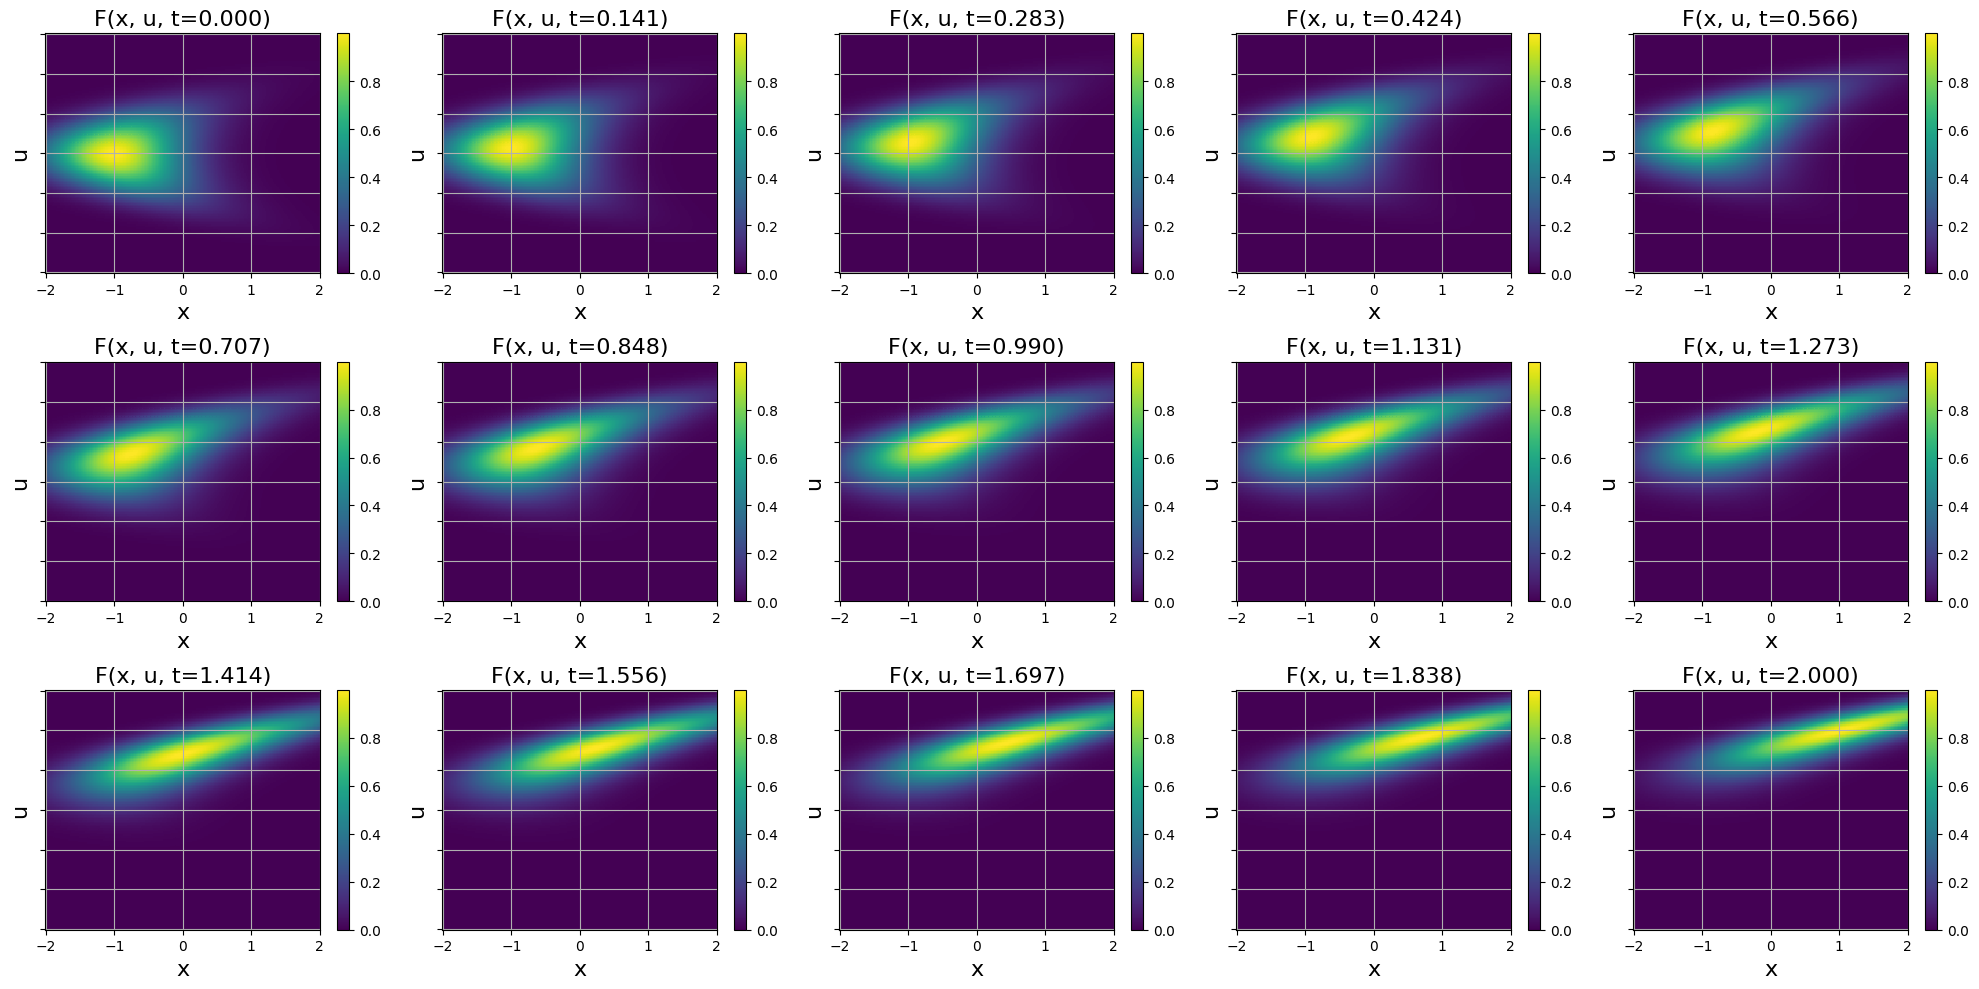

In [55]:
plt.figure(figsize=(20, 10))

for i, time in enumerate(np.linspace(0, len(t)-1, 15, dtype=int)):
    plt.subplot(3, 5, i+1)
    plt.pcolor(X3D[:,:,time], U3D[:,:,time], F[:, :, time])
    plt.xlabel("x", fontsize=16)
    plt.ylabel("u", fontsize=16)
    ax = plt.gca()
    ax.set_yticklabels([])
    plt.title(f"F(x, u, t={t[time]:.3f})", fontsize=16)
    plt.colorbar()
    plt.grid()

plt.tight_layout()
plt.show()


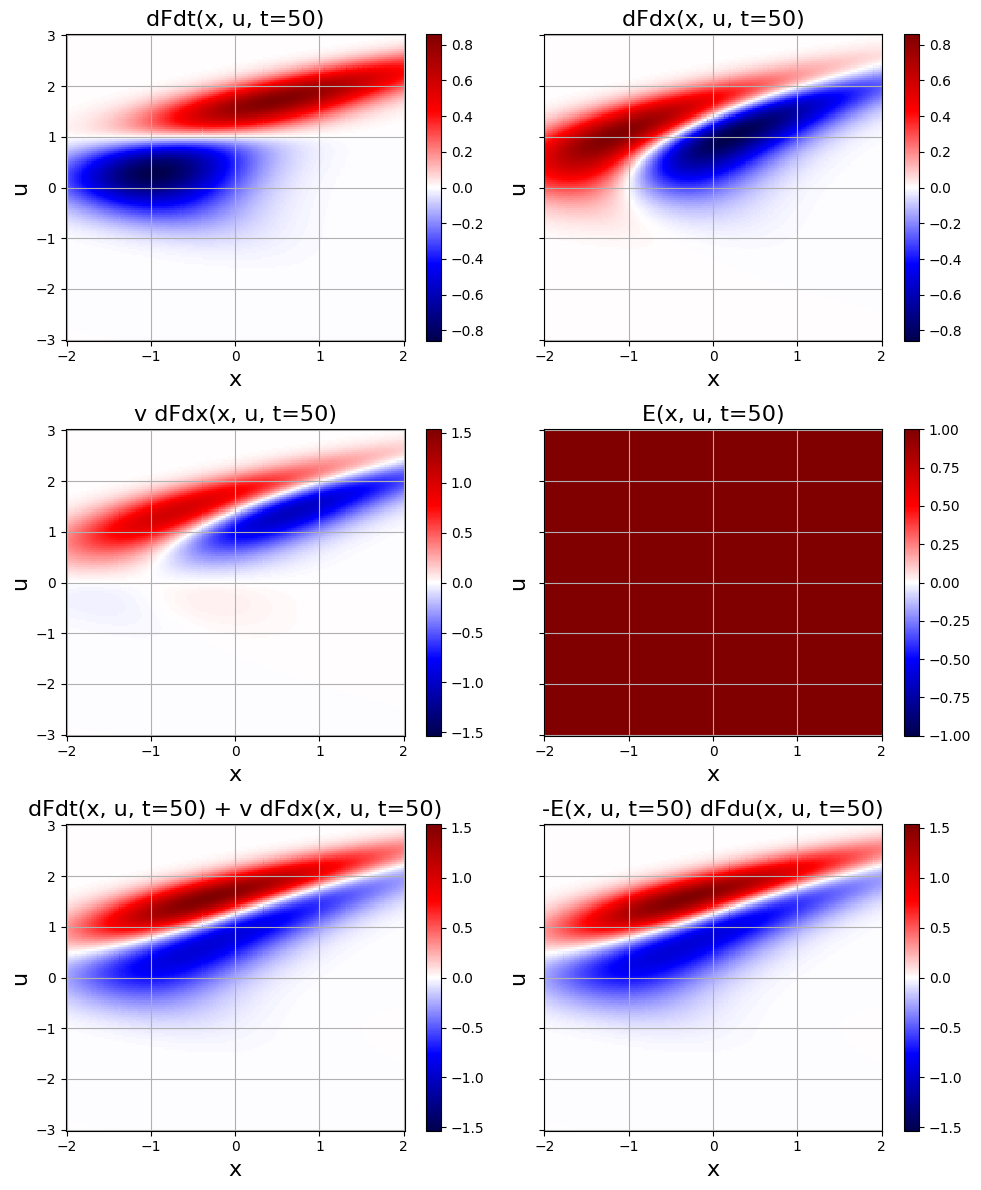

In [56]:
time = 50

dFdt = ps.SmoothedFiniteDifference(axis=2,smoother_kws={'window_length': 5})._differentiate(F, t=t)
dFdx = ps.SmoothedFiniteDifference(axis=0,smoother_kws={'window_length': 5})._differentiate(F, t=x)
dFdu = ps.SmoothedFiniteDifference(axis=1,smoother_kws={'window_length': 5})._differentiate(F, t=u)

plt.figure(figsize=(10, 12))

plt.subplot(3, 2, 1)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], dFdt[:, :, time], norm=colors.CenteredNorm(), cmap="seismic")
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
plt.title(f"dFdt(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 2)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], dFdx[:, :, time], norm=colors.CenteredNorm(), cmap="seismic")
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(f"dFdx(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 4)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], E[:,:,time], norm=colors.CenteredNorm(), cmap="seismic")
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(f"E(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 6)
pcm = plt.pcolor(X3D[:,:,time], U3D[:,:,time], -E[:,:,time]*dFdu[:, :, time], norm=colors.CenteredNorm(), cmap="seismic")
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(f"-E(x, u, t={time}) dFdu(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 5)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], dFdt[:, :, time] +V3D[:,:,time]*dFdx[:, :, time], cmap="seismic",vmin=pcm.norm.vmin,vmax=pcm.norm.vmax)
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
plt.title(f"dFdt(x, u, t={time}) + v dFdx(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 3)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], V3D[:,:,time]*dFdx[:, :, time], cmap="seismic",vmin=pcm.norm.vmin,vmax=pcm.norm.vmax)
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
plt.title(f"v dFdx(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.tight_layout()
plt.show()


In [38]:
# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x
]
library_function_names = [
    lambda x: x,
    lambda x: x + x
]

np.random.seed(100)

weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XUT,
    K=100,
)

In [57]:
# Fit the 2D reaction-diffusion equation, weak form style!
for threshold in [0.05, 0.09,0.1, 0.15, 0.2, 0.021,0.03]: # parameter sweep for threshold of coefficient elimination
    print("==========================================")
    for alpha in [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,0.05,0.1,0.5,1,10,100,1000]:   # parameter sweep for alpha of ridge regression
        optimizer = ps.STLSQ(threshold=threshold, alpha=alpha)
        model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
        model.fit(F[...,np.newaxis], u =V3D)
        print(f"threshold = {threshold:.3e}, alpha = {alpha:.3e}", end="\t")
        model.print()

threshold = 5.000e-02, alpha = 1.000e-08	(x0)' = -1.000 x0_2 + -1.000 u0x0_1
threshold = 5.000e-02, alpha = 1.000e-07	(x0)' = -1.000 x0_2 + -1.000 u0x0_1
threshold = 5.000e-02, alpha = 1.000e-06	(x0)' = -1.000 x0_2 + -0.001 x0x0_1 + -1.000 u0x0_1 + 0.001 x0x0x0_1 + -0.001 x0x0_12 + 0.001 x0x0x0_12
threshold = 5.000e-02, alpha = 1.000e-05	(x0)' = -1.000 x0_2 + 0.001 x0x0_2 + -0.001 x0x0x0_2 + -1.000 u0x0_1 + 0.001 x0x0x0_12
threshold = 5.000e-02, alpha = 1.000e-04	(x0)' = -0.636 x0_2 + -0.312 x0x0_2 + 0.226 u0x0_2
threshold = 5.000e-02, alpha = 1.000e-03	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-02	(x0)' = 0.000
threshold = 5.000e-02, alpha = 5.000e-02	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-01	(x0)' = 0.000
threshold = 5.000e-02, alpha = 5.000e-01	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e+00	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e+01	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e+02	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e+03	

### Alternative approach 
Here I expand the solution space the same way I did it in `pysindy/examples/5_differentiation/G_experiments/nonuniform.ipynb`

In [58]:
sol = np.stack([F,V3D],axis=-1)
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XUT,
    K=100,
)
sol.shape

(200, 150, 100, 2)

In [59]:
# Fit the 2D reaction-diffusion equation, weak form style!
for threshold in [0.05, 0.09,0.1, 0.15, 0.2, 0.021,0.03]: # parameter sweep for threshold of coefficient elimination
    print("==========================================")
    for alpha in [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,0.05,0.1,0.5,1,10,100,1000]:   # parameter sweep for alpha of ridge regression
        optimizer = ps.STLSQ(threshold=threshold, alpha=alpha)
        model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
        model.fit(sol)
        print(f"threshold = {threshold:.3e}, alpha = {alpha:.3e}", end="\t")
        model.print()

threshold = 5.000e-02, alpha = 1.000e-08	(x0)' = -1.000 x0_2 + -1.000 x1x0_1
(x1)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-07	(x0)' = -1.000 x0_2 + -1.000 x1x0_1
(x1)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-06	(x0)' = -1.000 x0_2 + 0.001 x0x0_2 + -1.000 x1x0_1
(x1)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-05	(x0)' = -1.000 x0_2 + 0.001 x0x0_2 + -1.000 x1x0_1
(x1)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-04	(x0)' = -1.000 x0_2 + 0.001 x0x0_2 + -1.000 x1x0_1
(x1)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-03	(x0)' = 0.000
(x1)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-02	(x0)' = 0.000
(x1)' = 0.000
threshold = 5.000e-02, alpha = 5.000e-02	(x0)' = 0.000
(x1)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-01	(x0)' = 0.000
(x1)' = 0.000
threshold = 5.000e-02, alpha = 5.000e-01	(x0)' = 0.000
(x1)' = 0.000
threshold = 5.000e-02, alpha = 1.000e+00	(x0)' = 0.000
(x1)' = 0.000
threshold = 5.000e-02, alpha = 1.000e+01	(x0)' = 0.000
(x1)' = 0.000
threshold = 5.000

## Spatial dependence of the electric field

In principle it is possible to introduce spatial dependence of the electric field $E(x) = -\omega^2 x$ in the nonrelativisic case and still extract a solution via the method of characteristics. In this case the solution can be written as arbitrary function of the following arguments
$$
f = F(v^2+\omega^2 x^2, \omega t - \arctan(\omega x/v))
$$
Again, we do not concern ourselves with the physical consistency of the solution, but rather with the ability of the algorithm to recover the equation from data.

In [76]:
t = np.linspace(0, 2, 100)
x = np.linspace(-1.5, 1.5, 200)
u = np.linspace(-1.5, 1.5, 150)
v = u
omega = 1
X3D, U3D, T3D = np.meshgrid(x, u, t, indexing="ij")
V3D = U3D # because non-relativistic
XUT = np.transpose([X3D, U3D, T3D], [1, 2, 3, 0])
print(f"{X3D.shape=}, {U3D.shape=}, {T3D.shape=}, {XUT.shape=}")

X3D.shape=(200, 150, 100), U3D.shape=(200, 150, 100), T3D.shape=(200, 150, 100), XUT.shape=(200, 150, 100, 3)


In [77]:
Xi = U3D**2 +  omega**2*X3D**2
Eta = omega*T3D - np.arctan2(omega*X3D,V3D)
F = np.exp(-(Eta)**2-Xi**2)
E = -omega**2*X3D
#F = F/np.trapz(F, v, axis=1)[:,np.newaxis,:] # normalizing F just in case

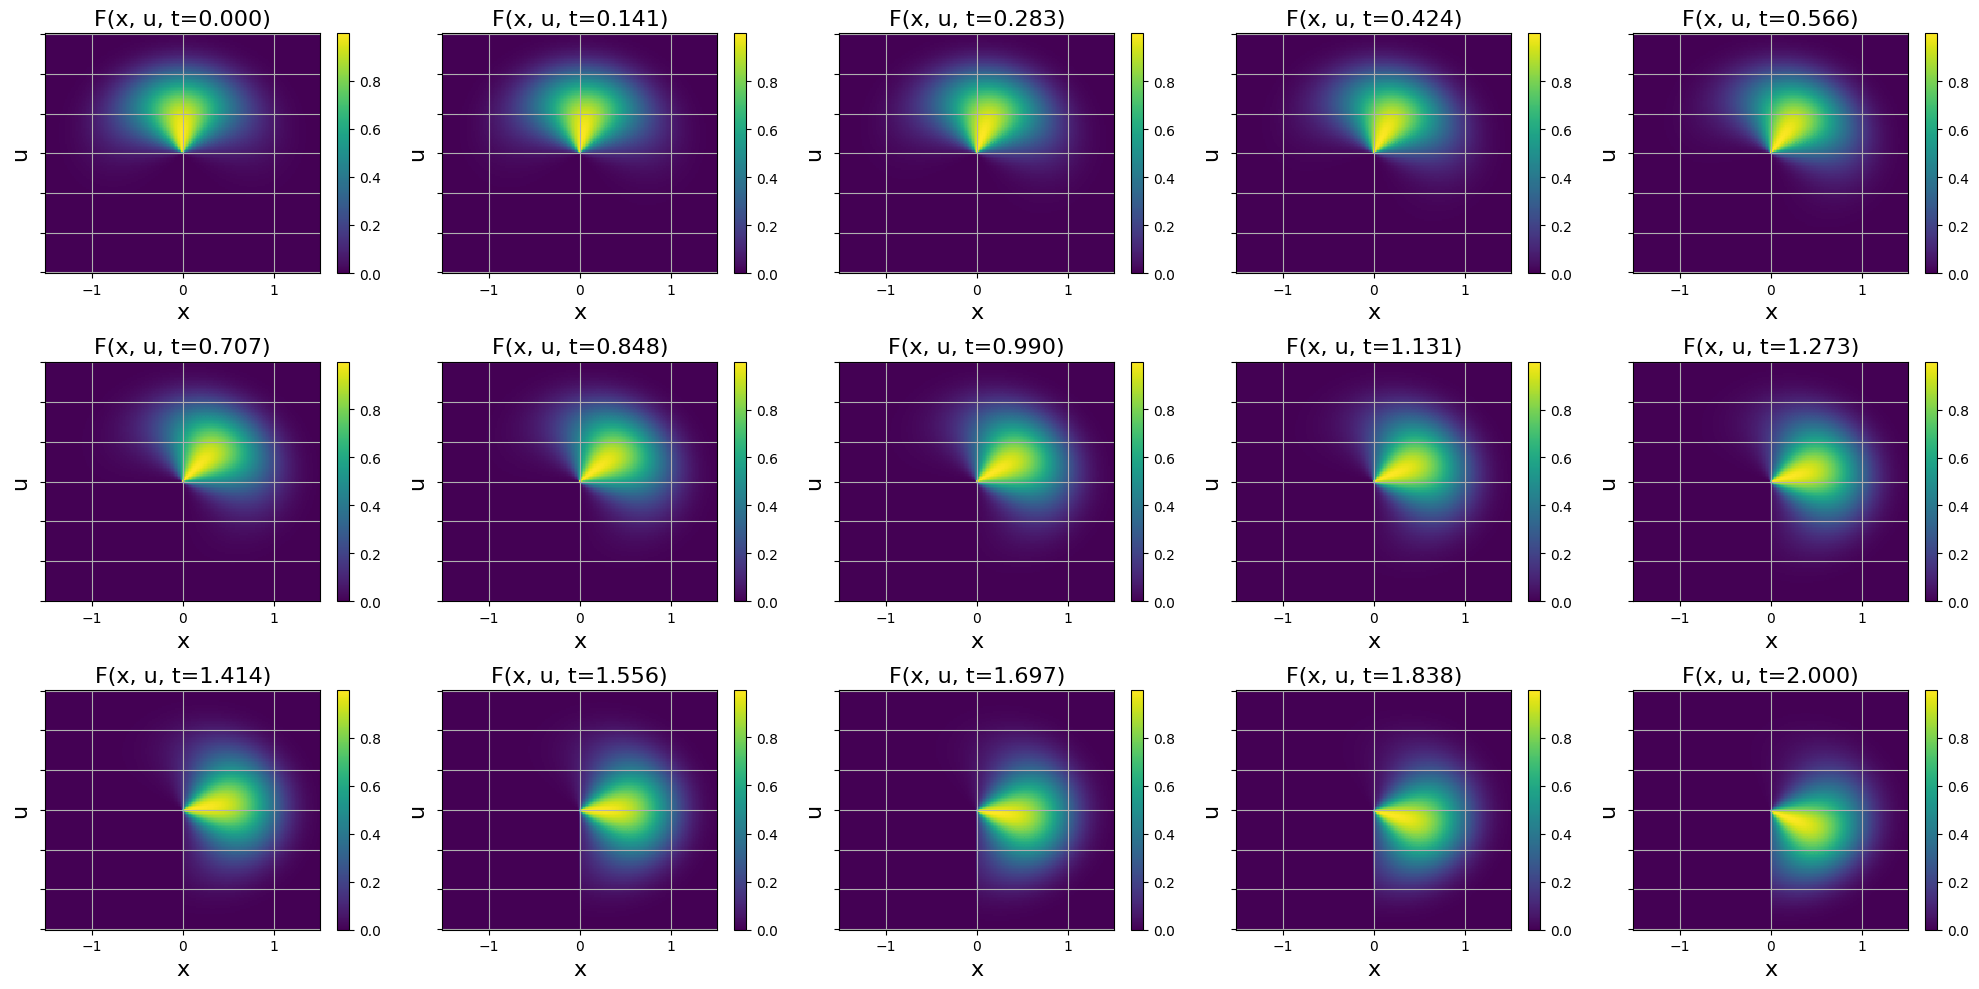

In [78]:
plt.figure(figsize=(20, 10))

for i, time in enumerate(np.linspace(0, len(t)-1, 15, dtype=int)):
    plt.subplot(3, 5, i+1)
    plt.pcolor(X3D[:,:,time], U3D[:,:,time], F[:, :, time])
    plt.xlabel("x", fontsize=16)
    plt.ylabel("u", fontsize=16)
    ax = plt.gca()
    ax.set_yticklabels([])
    plt.title(f"F(x, u, t={t[time]:.3f})", fontsize=16)
    plt.colorbar()
    plt.grid()

plt.tight_layout()
plt.show()


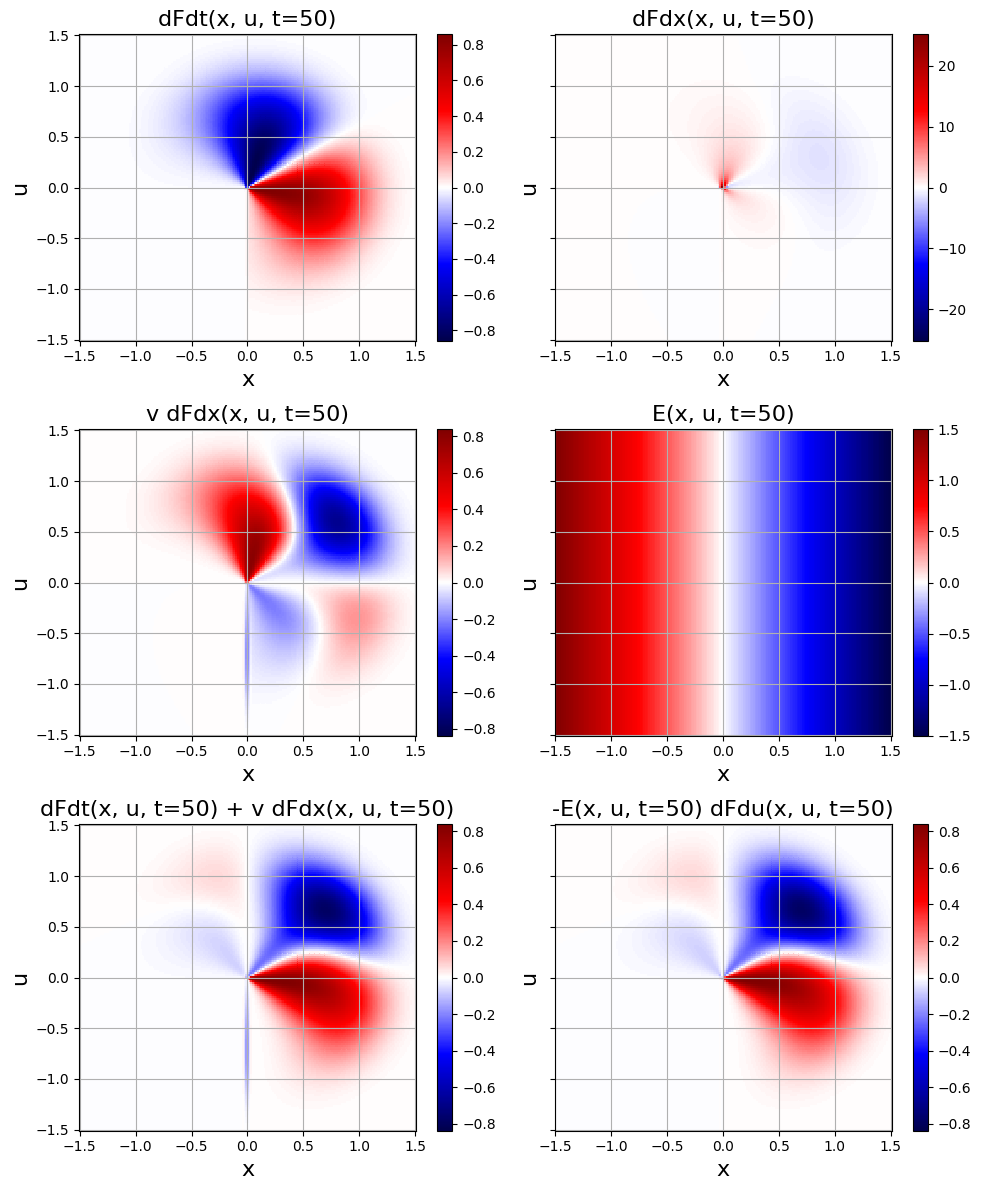

In [79]:
time = 50

dFdt = ps.SmoothedFiniteDifference(axis=2,smoother_kws={'window_length': 5})._differentiate(F, t=t)
dFdx = ps.SmoothedFiniteDifference(axis=0,smoother_kws={'window_length': 5})._differentiate(F, t=x)
dFdu = ps.SmoothedFiniteDifference(axis=1,smoother_kws={'window_length': 5})._differentiate(F, t=u)

plt.figure(figsize=(10, 12))

plt.subplot(3, 2, 1)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], dFdt[:, :, time], norm=colors.CenteredNorm(), cmap="seismic")
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
plt.title(f"dFdt(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 2)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], dFdx[:, :, time], norm=colors.CenteredNorm(), cmap="seismic")
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(f"dFdx(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 4)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], E[:,:,time], norm=colors.CenteredNorm(), cmap="seismic")
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(f"E(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 6)
pcm = plt.pcolor(X3D[:,:,time], U3D[:,:,time], -E[:,:,time]*dFdu[:, :, time], norm=colors.CenteredNorm(), cmap="seismic")
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(f"-E(x, u, t={time}) dFdu(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 5)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], dFdt[:, :, time] +V3D[:,:,time]*dFdx[:, :, time], cmap="seismic",vmin=pcm.norm.vmin,vmax=pcm.norm.vmax)
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
plt.title(f"dFdt(x, u, t={time}) + v dFdx(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.subplot(3, 2, 3)
plt.pcolor(X3D[:,:,time], U3D[:,:,time], V3D[:,:,time]*dFdx[:, :, time], cmap="seismic",vmin=pcm.norm.vmin,vmax=pcm.norm.vmax)
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
plt.title(f"v dFdx(x, u, t={time})", fontsize=16)
plt.colorbar()
plt.grid()

plt.tight_layout()
plt.show()


In [80]:
# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x
]
library_function_names = [
    lambda x: x,
    lambda x: x + x
]

np.random.seed(100)

weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XUT,
    K=100,
)

In [81]:
# Fit the 2D reaction-diffusion equation, weak form style!
for threshold in [0.05, 0.09,0.1, 0.15, 0.2, 0.021,0.03]: # parameter sweep for threshold of coefficient elimination
    print("==========================================")
    for alpha in [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,0.05,0.1,0.5,1,10,100,1000]:   # parameter sweep for alpha of ridge regression
        optimizer = ps.STLSQ(threshold=threshold, alpha=alpha)
        model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
        model.fit(F[...,np.newaxis], u =np.stack([V3D,E],axis=-1))
        print(f"threshold = {threshold:.3e}, alpha = {alpha:.3e}", end="\t")
        model.print()

threshold = 5.000e-02, alpha = 1.000e-08	(x0)' = -1.000 u1x0_2 + -0.992 u0x0_1
threshold = 5.000e-02, alpha = 1.000e-07	(x0)' = -0.998 u1x0_2 + -0.982 u0x0_1 + -0.027 u0u0x0_1
threshold = 5.000e-02, alpha = 1.000e-06	(x0)' = -0.005 x0_2 + -0.005 x0_1 + 0.006 x0x0_2 + -1.010 u1x0_2 + -0.021 u1u1x0_2 + 0.003 u1u1x0_22 + -0.996 u0x0_1 + 0.027 u0u0x0_1 + 0.011 u0x0_12 + -0.007 u0u0x0_12 + -0.001 u1u1x0_12
threshold = 5.000e-02, alpha = 1.000e-05	(x0)' = -0.001 x0_2 + -0.006 x0_1 + 0.007 x0x0_2 + -0.995 u1x0_2 + -0.983 u0x0_1 + -0.001 u0u0x0_12 + 0.002 u1u1x0_12
threshold = 5.000e-02, alpha = 1.000e-04	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-03	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-02	(x0)' = 0.000
threshold = 5.000e-02, alpha = 5.000e-02	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e-01	(x0)' = 0.000
threshold = 5.000e-02, alpha = 5.000e-01	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e+00	(x0)' = 0.000
threshold = 5.000e-02, alpha = 1.000e+01	(x0)' = 0.